<a href="https://colab.research.google.com/github/canmike/qmn-house-price-prediction/blob/main/QNN_house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Mon Mar 17 12:53:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   77C    P0             36W /   72W |     329MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%pip install -q pennylane pennylane-lightning-gpu

# 1. Load & Preprocess Data

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Load the California Housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Normalize features and target
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

len(X_train), len(X_test)

cuda:0


(16512, 4128)

In [ ]:
import pandas as pd
df = pd.DataFrame(X, columns=data.feature_names)
df[data.target_names[0]] = y

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.344766,0.982143,0.628559,-0.153758,-0.974429,-0.049597,1.052548,-1.327835,2.129631
1,2.332238,-0.607019,0.327041,-0.263336,0.861439,-0.092512,1.043185,-1.322844,1.314156
2,1.782699,1.856182,1.155620,-0.049016,-0.820777,-0.025843,1.038503,-1.332827,1.258693
3,0.932968,1.856182,0.156966,-0.049833,-0.766028,-0.050329,1.038503,-1.337818,1.165100
4,-0.012881,1.856182,0.344711,-0.032906,-0.759847,-0.085616,1.038503,-1.337818,1.172900


# 2. Define the Quantum Neural Network

In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Define the number of qubits (equal to number of features)
n_qubits = 8  # California Housing has 8 features
n_layers = 8  # Number of variational layers

# Define the quantum device
dev = qml.device("lightning.gpu", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    # Encode the classical input data into quantum states
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)

    # Variational quantum circuit
    for l in range(n_layers):
        # Entangling layer
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])

        # Rotation layer with trainable weights
        for i in range(n_qubits):
            qml.RX(weights[l][i][0], wires=i)
            qml.RY(weights[l][i][1], wires=i)
            qml.RZ(weights[l][i][2], wires=i)

    # Measure the expectation value of Z on the first qubit
    return qml.expval(qml.PauliZ(0))

# Define the hybrid quantum-classical model
class QuantumNeuralNetwork(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumNeuralNetwork, self).__init__()

        # Initialize trainable weights for the quantum circuit
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

        # Classical output layer to adjust the range of predictions
        self.post_processing = nn.Linear(1, 1)

    def forward(self, x):
        # Process each sample individually to handle batching correctly
        batch_size = x.shape[0]
        q_out = torch.zeros(batch_size, device=x.device)

        for i in range(batch_size):
            q_out[i] = self.qlayer(x[i])

        # Reshape and apply the classical layer
        q_out = q_out.reshape(-1, 1)
        return self.post_processing(q_out).squeeze()


# Create the model
model = QuantumNeuralNetwork(n_qubits, n_layers).to(device)
print(model)

QuantumNeuralNetwork(
  (qlayer): <Quantum Torch Layer: func=quantum_circuit>
  (post_processing): Linear(in_features=1, out_features=1, bias=True)
)


# 3. Training Loop

In [ ]:
from tqdm import tqdm

def train_qnn(model, X_train, y_train, X_test, y_test, epochs=10, batch_size=32, lr=0.01):
    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Prepare for batching
    n_samples = len(X_train)
    n_batches = int(np.ceil(n_samples / batch_size))

    # Track metrics
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        # Shuffle the training data
        indices = torch.randperm(n_samples)
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]

        for i in tqdm(range(n_batches)):
            # Prepare batch
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)

            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * (end_idx - start_idx)

        # Calculate average loss for the epoch
        epoch_loss /= n_samples
        train_losses.append(epoch_loss)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            y_pred_test = model(X_test)
            test_loss = criterion(y_pred_test, y_test).item()
            test_losses.append(test_loss)

        if (epoch + 1) % 1 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.6f}, Test Loss: {test_loss:.6f}")

    return model, train_losses, test_losses

In [ ]:
model, train_losses, test_losses = train_qnn(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=5,
    batch_size=32,
    lr=0.01
)

100%|██████████| 516/516 [24:15<00:00,  2.82s/it]


Epoch 1/5, Train Loss: 0.636226, Test Loss: 0.498270


100%|██████████| 516/516 [24:24<00:00,  2.84s/it]


Epoch 2/5, Train Loss: 0.454275, Test Loss: 0.444501


100%|██████████| 516/516 [24:27<00:00,  2.84s/it]


Epoch 3/5, Train Loss: 0.420840, Test Loss: 0.421852


100%|██████████| 516/516 [24:27<00:00,  2.84s/it]


Epoch 4/5, Train Loss: 0.399530, Test Loss: 0.401322


100%|██████████| 516/516 [24:28<00:00,  2.85s/it]


Epoch 5/5, Train Loss: 0.381625, Test Loss: 0.407900


In [ ]:
train_losses, test_losses

([0.6362261816917002,
  0.4542751034447389,
  0.4208398331678653,
  0.39952951629263483,
  0.38162496634000953],
 [0.4982704818248749,
  0.4445008337497711,
  0.4218515455722809,
  0.4013216495513916,
  0.4079001247882843])

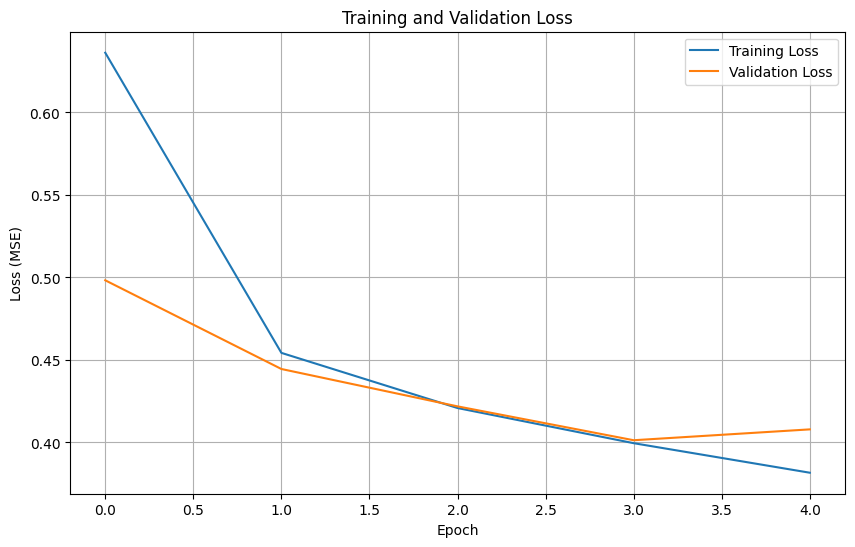

In [ ]:
def plot_training_history(train_losses, test_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(train_losses, test_losses)

# 4. Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, scaler_y=None):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).cpu().numpy()
        y_true = y_test.cpu().numpy()

        # If data was scaled, transform back to original scale for interpretable metrics
        if scaler_y is not None:
            y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
            y_true = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()

        # Calculate metrics
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        # Calculate MAPE (Mean Absolute Percentage Error)
        # Adding a small epsilon to prevent division by zero
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100

        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"R² Score: {r2:.4f}")
        print(f"MAPE: {mape:.2f}%")

        return y_pred


In [ ]:
print("\nEvaluation Metrics:")
y_pred = evaluate_model(model, X_test, y_test, scaler_y)


Evaluation Metrics:
MSE: 0.5431
RMSE: 0.7370
R² Score: 0.5855
MAPE: 27.81%


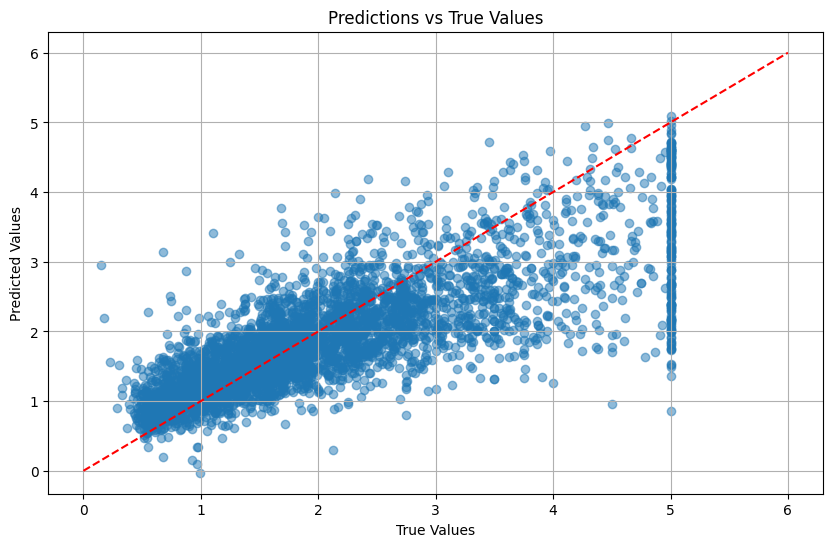

In [ ]:
unscaled_y_true = scaler_y.inverse_transform(y_test.cpu().reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.scatter(unscaled_y_true, y_pred, alpha=0.5)
plt.plot([0, 6], [0, 6], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs True Values')
plt.grid(True)
plt.show()